In [1]:
from __future__ import annotations
import deepscratch
from deepscratch.typing import PyTree

from deepscratch.dataset.vision import ImageNet
from deepscratch.dataset.base import DataLoader
from deepscratch.models.base import LinearBlock, Sequential
from deepscratch.models.vision.cnn import ConvBlock
from deepscratch.initialisers import Gaussian, Zeros
from deepscratch.activations import ReLU, Softmax, Activation
from deepscratch.optimisers import SGD, Adam
from deepscratch.losses import CrossEntropy, Accuracy
from deepscratch.transformations import Reshape, AvgPool

import jax.numpy as jnp

import matplotlib.pyplot as plt

deepscratch.dataset.vision
deepscratch.dataset.base
deepscratch.models.base
deepscratch.initialisers
deepscratch.activations
deepscratch.optimisers


deepscratch.losses
deepscratch.transformations
Metal device set to: Apple M3

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



W0000 00:00:1739874477.215277 8354926 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1739874477.235252 8354926 service.cc:145] XLA service 0x1178beeb0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739874477.235402 8354926 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1739874477.236606 8354926 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1739874477.236614 8354926 mps_client.cc:384] XLA backend will use up to 11452776448 bytes on device 0 for SimpleAllocator.


deepscratch.models.vision.cnn


In [2]:
BATCH_SIZE = 256
ds = ImageNet(ohe=True)
dl = DataLoader(ds, BATCH_SIZE, shuffle=True, num_workers=16, drop_last=True)

x0, y0 = ds[0]
H, W, C = x0.shape

## AlexNet

In [3]:
ann = Sequential([
    ConvBlock(3,6,5, stride=2),
    ReLU(),
    AvgPool(2,stride=2),
    ConvBlock(6,16,5),
    ReLU(),
    AvgPool(2,stride=2),
    Reshape((BATCH_SIZE, -1)),
    LinearBlock(4624, 84),
    ReLU(),
    LinearBlock(84, len(ds.class_to_idx)),
    Softmax()
])

In [4]:
ann.train(
    dl,
    CrossEntropy(),
    Adam,
    lr=1e-4,
    epochs=4,
    device="METAL"
)

Iter: 144	Step: 5.7E-02	Loss: 1.693E+00


In [5]:
x_misclf = []
y_misclf = []
y_est_misclf = []
acc = 0

for batch in dl:
    x, y = batch
    y_est = ann.forward(x).argmax(axis=1)
    y = y.argmax(axis=1)

    acc += (y_est == y).sum()
    x_misclf.append(x[y_est != y])
    y_est_misclf.append(y_est[y_est != y])
    y_misclf.append(y[y_est != y])

x_mis_clf = jnp.vstack(x_misclf)
y_est_misclf = jnp.hstack(y_est_misclf)
y_mis_clf = jnp.hstack(y_misclf)

print(f"Accuracy: {acc / len(ds):.3%}")

Accuracy: 38.336%


## Where did the model go wrong?

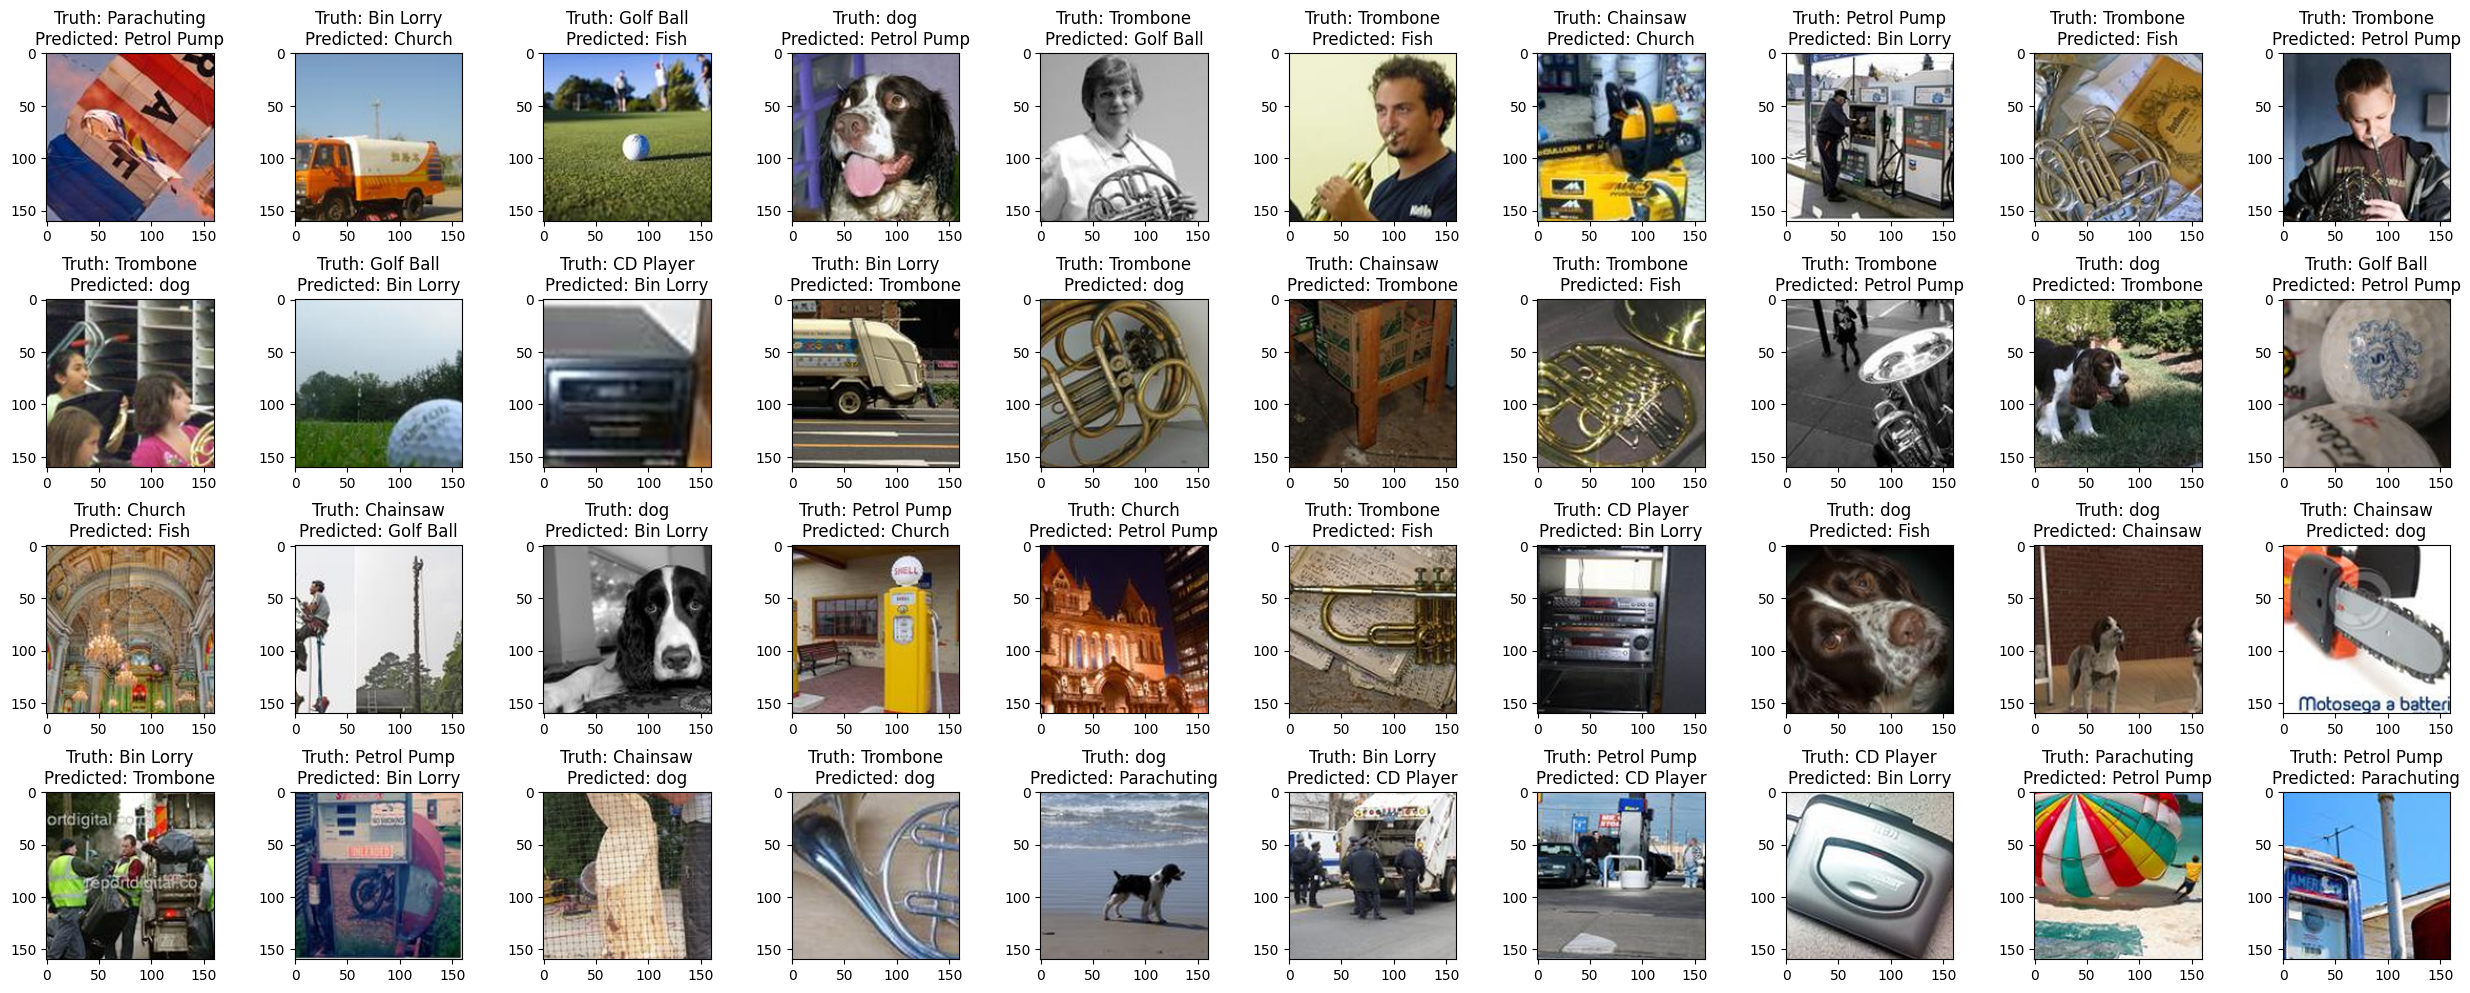

In [16]:
fig, axs = plt.subplots(4, 10, figsize=(25,10))

for xi, y_esti, yi, ax in zip(x_mis_clf, y_est_misclf, y_mis_clf, axs.flatten()):
    ax.imshow(xi)

    ax.set_title(f"Truth: {ds.idx_to_class[int(yi)]}\nPredicted: {ds.idx_to_class[int(y_esti)]}")

fig.tight_layout()